In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2

import os, sys
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import healpy as hp

sys.path.append('../src/')
import needlets
import nilc
from utils import *

In [10]:
# l_peaks = [0,100,200,350,500]
# l_mins = [0,0,100,200,350]
# l_maxs = [100,200,350,500,500]
# cos = needlets.CosineNeedlet(l_peaks,l_mins,l_maxs)

theta_fwhms_arcmin = [600, 300, 120, 60, 30, 15, 10, 7.5, 5]
l_max = 3000
gauss = needlets.GaussianNeedlet(theta_fwhms_arcmin, l_max)


In [11]:
# loading SPT sims and adding noise to them
PATH_SIMS = '/Users/anacarolinaoliveira/Documents/Documents_2/Stanford/CMB/Code/spt_sims'
spt = DetSpecs(det='SPT')
noise_eff = spt.noise_eff(np.arange(5000))
noise_alms = [hp.synalm(i, lmax=5000) for i in noise_eff]

spt_files = [f'{PATH_SIMS}/spt3g_{int(nu)}ghz_cmb_tszmasked_cib_alms.fits' for nu in spt.bands]
spt_alms = np.array([hp.read_alm(i, hdu=1, return_mmax=False) for i in spt_files])

for i in range(len(spt_alms)):
    spt_alms[i] += noise_alms[i]

spt_noisy_maps = [hp.alm2map(i, 2**10) for i in spt_alms]

# some other necessary detector info
freqs = [str(int(i)) for i in spt.bands]
beams = {freqs[i]: spt.beam_size_fwhm_arcmin[i] for i in range(spt.nb)}

/Users/anacarolinaoliveira/Documents/Documents_2/Stanford/CMB/NeeLC/notebooks/../src/utils.py:119: RuntimeWarning: divide by zero encountered in power
  noise_eff[b] = (np.square(self.white_noise[b])*(1+(L/self.l_knee[b])**self.alpha[b]))/np.square(beam[b]) # in muK^2-radians^2


/Users/anacarolinaoliveira/Documents/Documents_2/Stanford/CMB/NeeLC/notebooks/../src/needlets.py:118: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  betajk = hp.alm2map(alm, lmax=self.l_maxs[j], nside=self.nside[j], verbose=False)


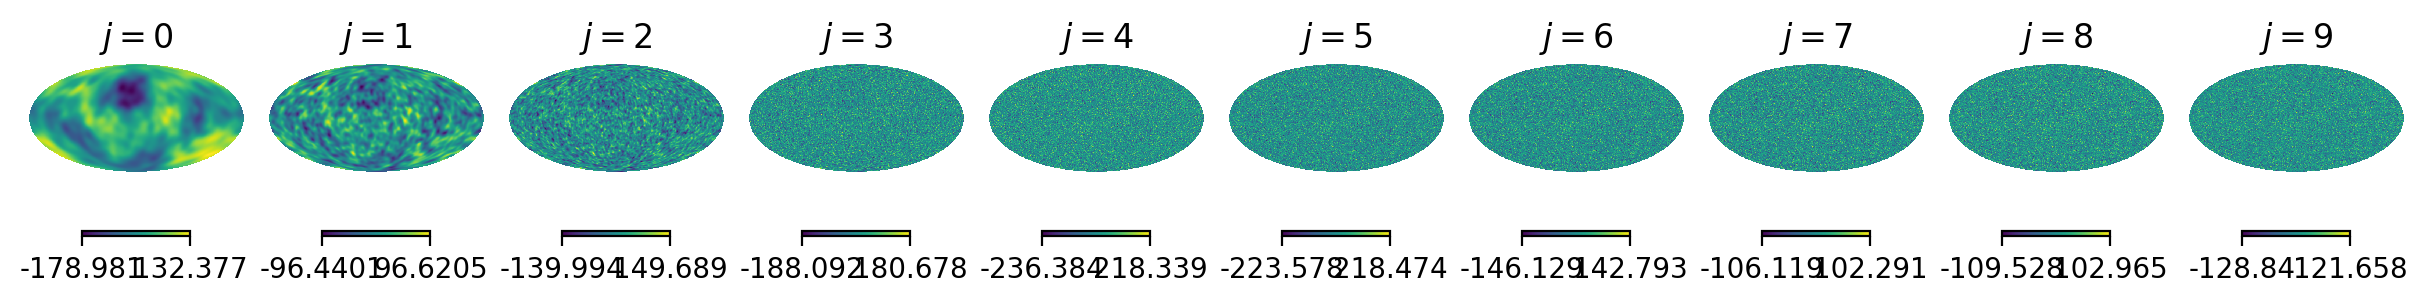

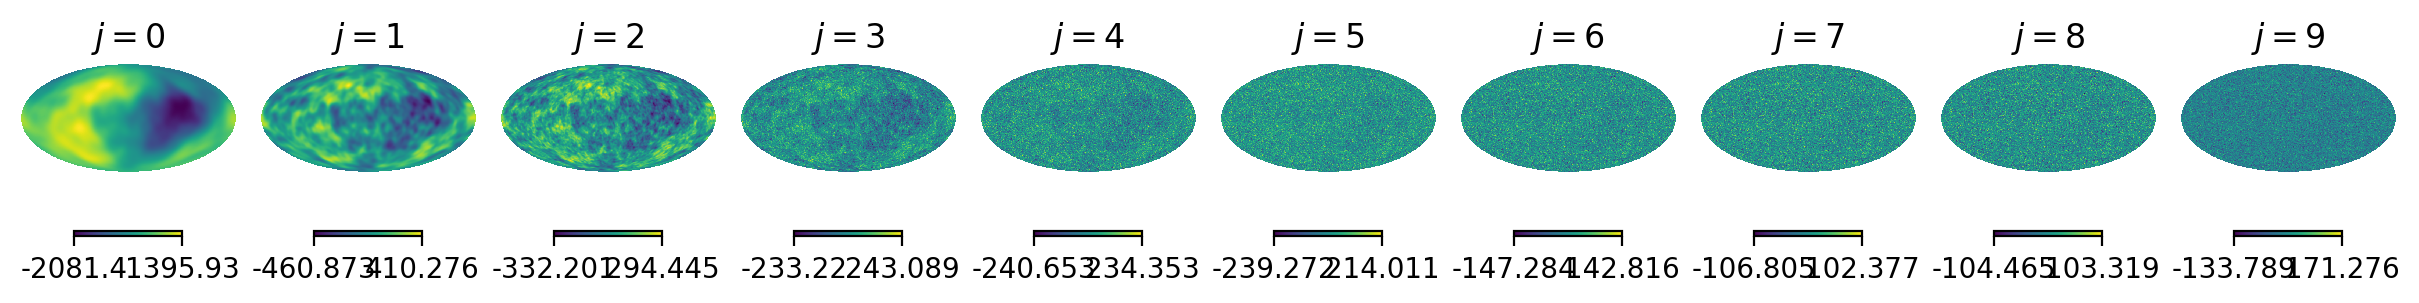

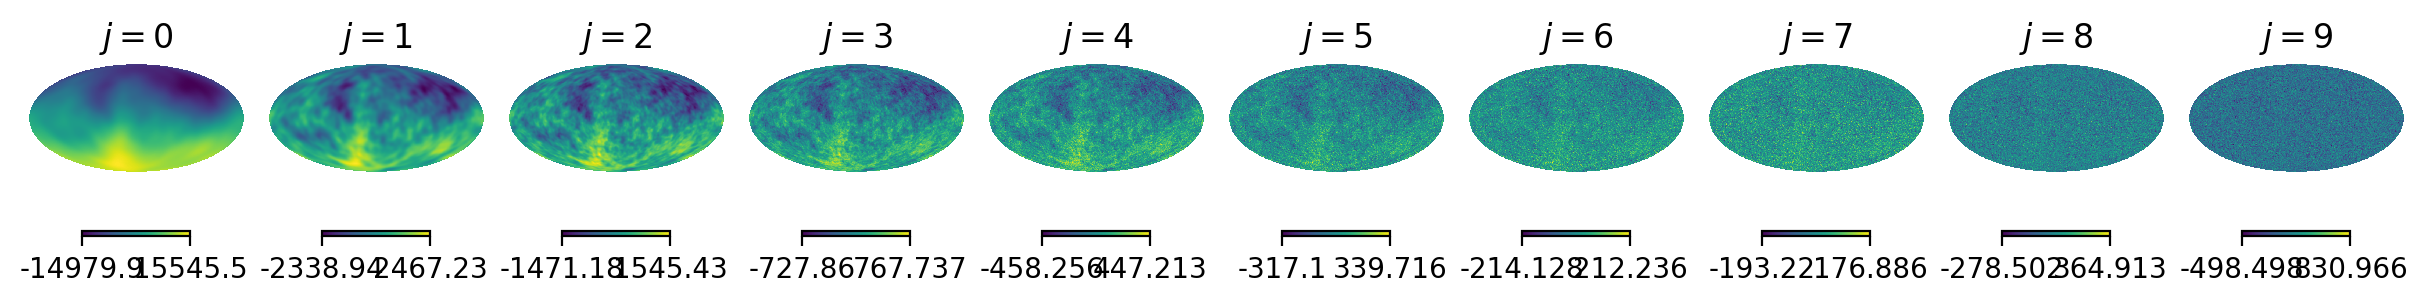

In [17]:
bjk = {j: np.array([gauss.map2betajk(spt_noisy_maps[i], j) for i in range(len(spt_noisy_maps))]) for j in range(gauss.nbands)}

for i in range(len(spt_noisy_maps)):
    plt.figure(figsize=(12,6))
    for j in range(gauss.nbands):
        hp.mollview(bjk[j][i], title=r'$j={}$'.format(j), sub=(1,gauss.nbands,j+1),)# min=-1, max=1)
    plt.show()
    plt.close()

In [ ]:
# initiating needlet object and getting covariance matrix from the simulated maps
n = nilc.NILC(gauss, freqs, beams)
cov = n.get_betajk_cov(betajk=bjk)

#### Test Case 1: CMB MV

In [ ]:
w_CMB, noise_pred = n.get_weights(betajk_cov=cov)
cmb_map = n.separate_betajk(betajk=bjk, weights=w_CMB)

In [ ]:
print(np.transpose(w_CMB[0])[1])

[[-0.00301906 -0.00268371 -0.00360256 ...  0.01675095  0.01684488
   0.01653049]]


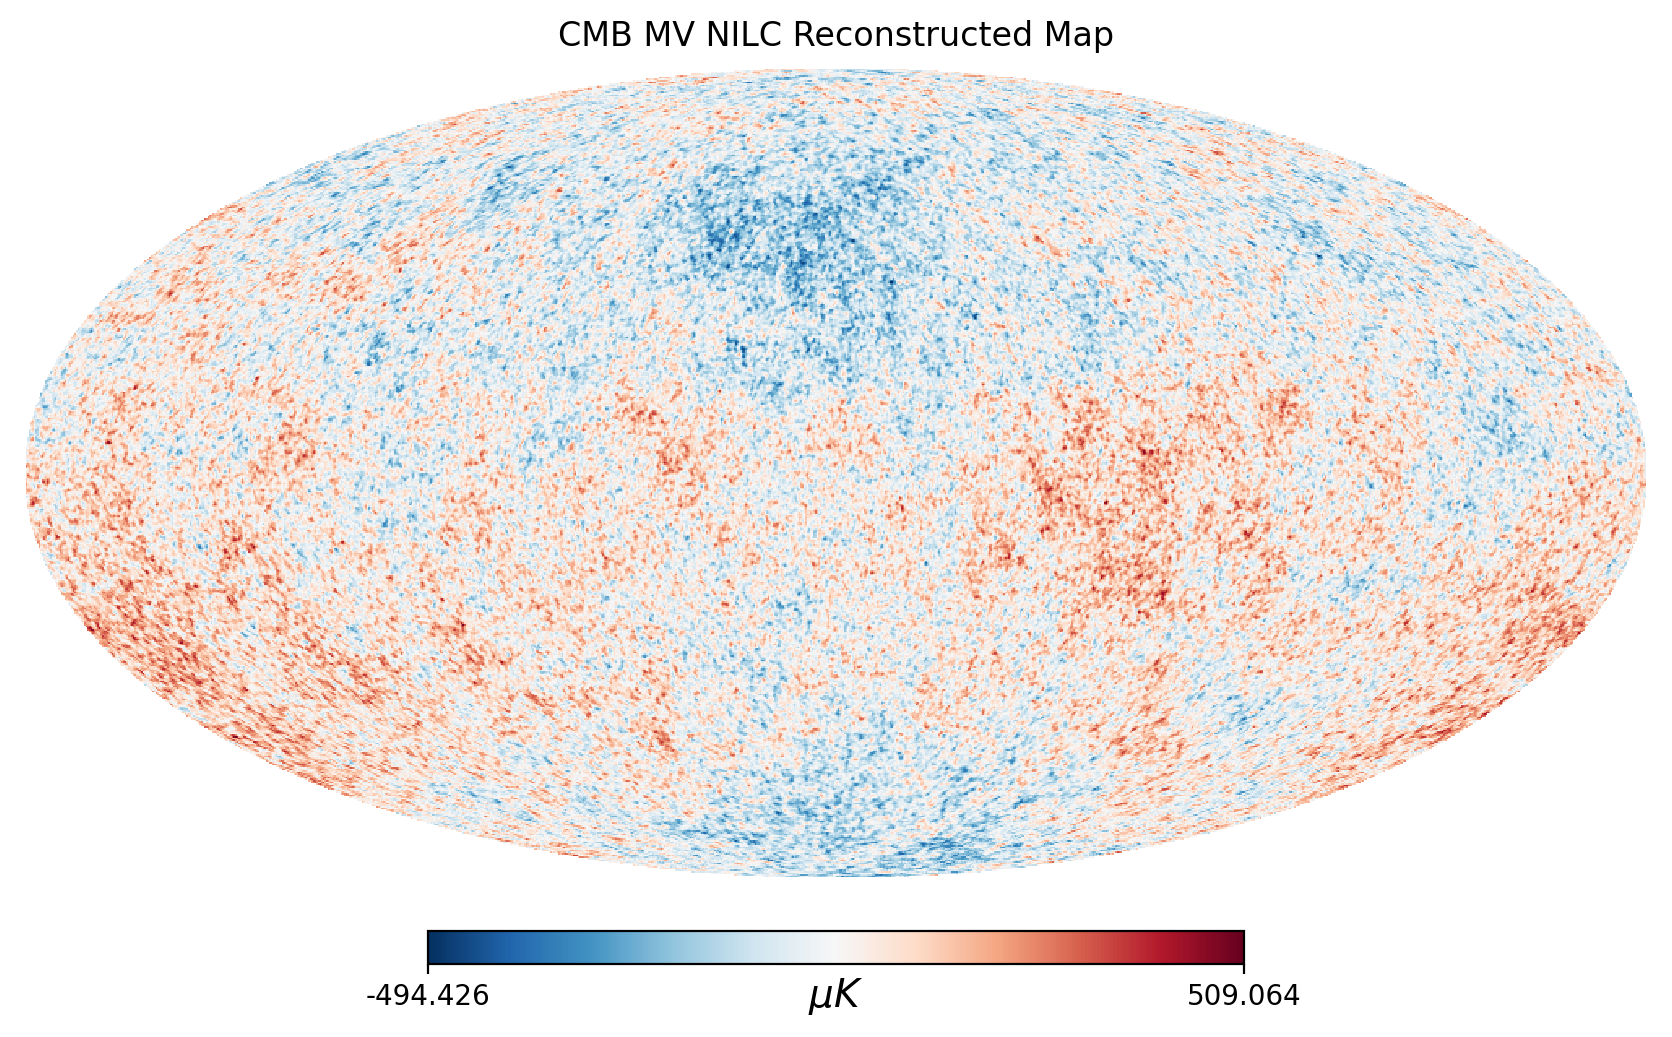

In [ ]:
# CMB map 
hp.mollview(cmb_map[0], unit=r'$\mu K$', xsize=1000, cmap=cm.RdBu_r, title="CMB MV NILC Reconstructed Map")

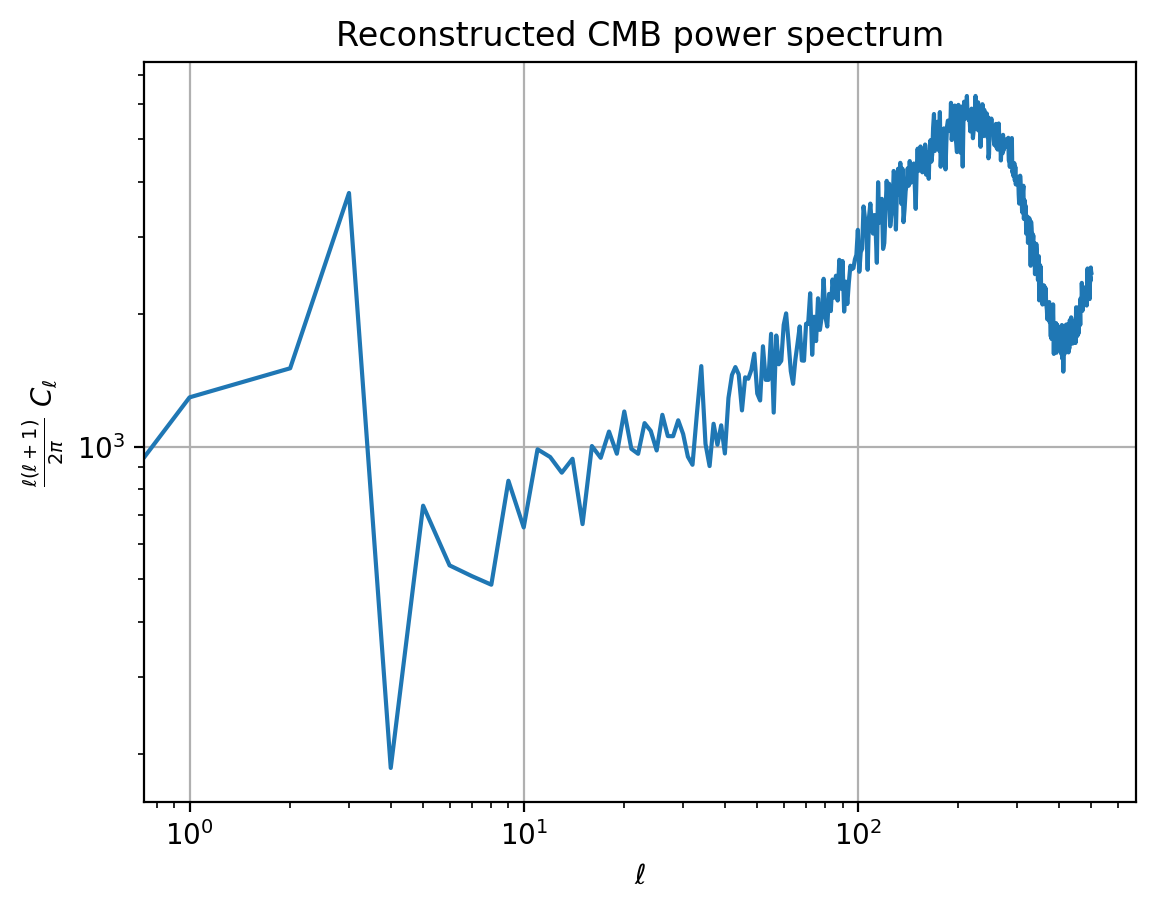

In [ ]:
# checking the power spectrum 
Cl_cmb = hp.anafast(cmb_map[0], lmax=cos.l_max)
ell = np.arange(cos.l_max+1)
Dl_cmb = cl2dl(Cl_cmb, ell)

plt.loglog(ell, Dl_cmb)
plt.grid()
plt.xlabel(r"$\ell$")
plt.ylabel(r'$\frac{\ell(\ell+1)}{2\pi}~C_{\ell}$')
plt.title("Reconstructed CMB power spectrum")
plt.show()

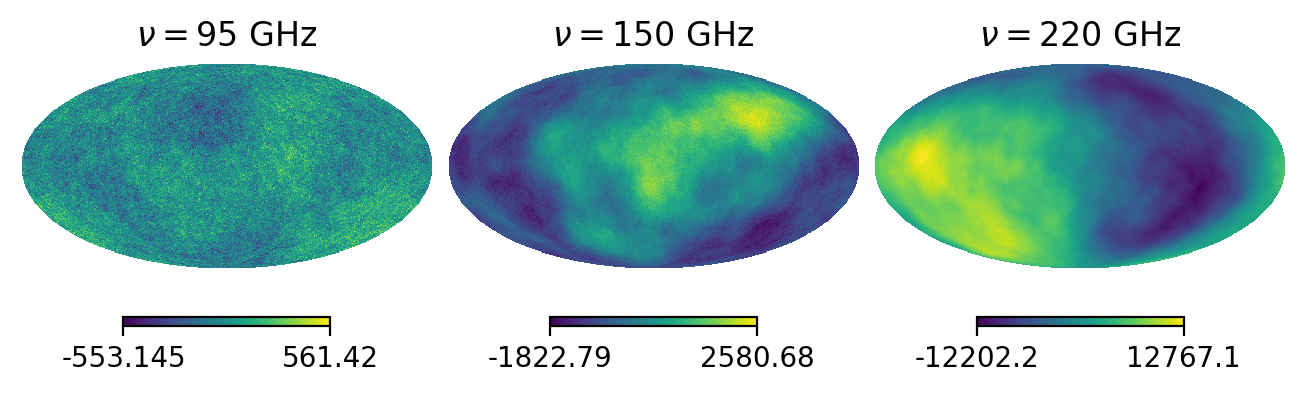

In [ ]:
# input maps for comparison
for nu in range(len(freqs)):
    hp.mollview(spt_noisy_maps[nu], title=rf'$\nu={freqs[nu]}$ GHz', sub=(1,len(freqs),nu+1),)

#### Test Case 1: tSZ MV

In [ ]:
w_tSZ, noise_pred = n.get_weights(betajk_cov=cov, cmb=False, tsz=True)
tsz_map = n.separate_betajk(betajk=bjk, weights=w_tSZ)

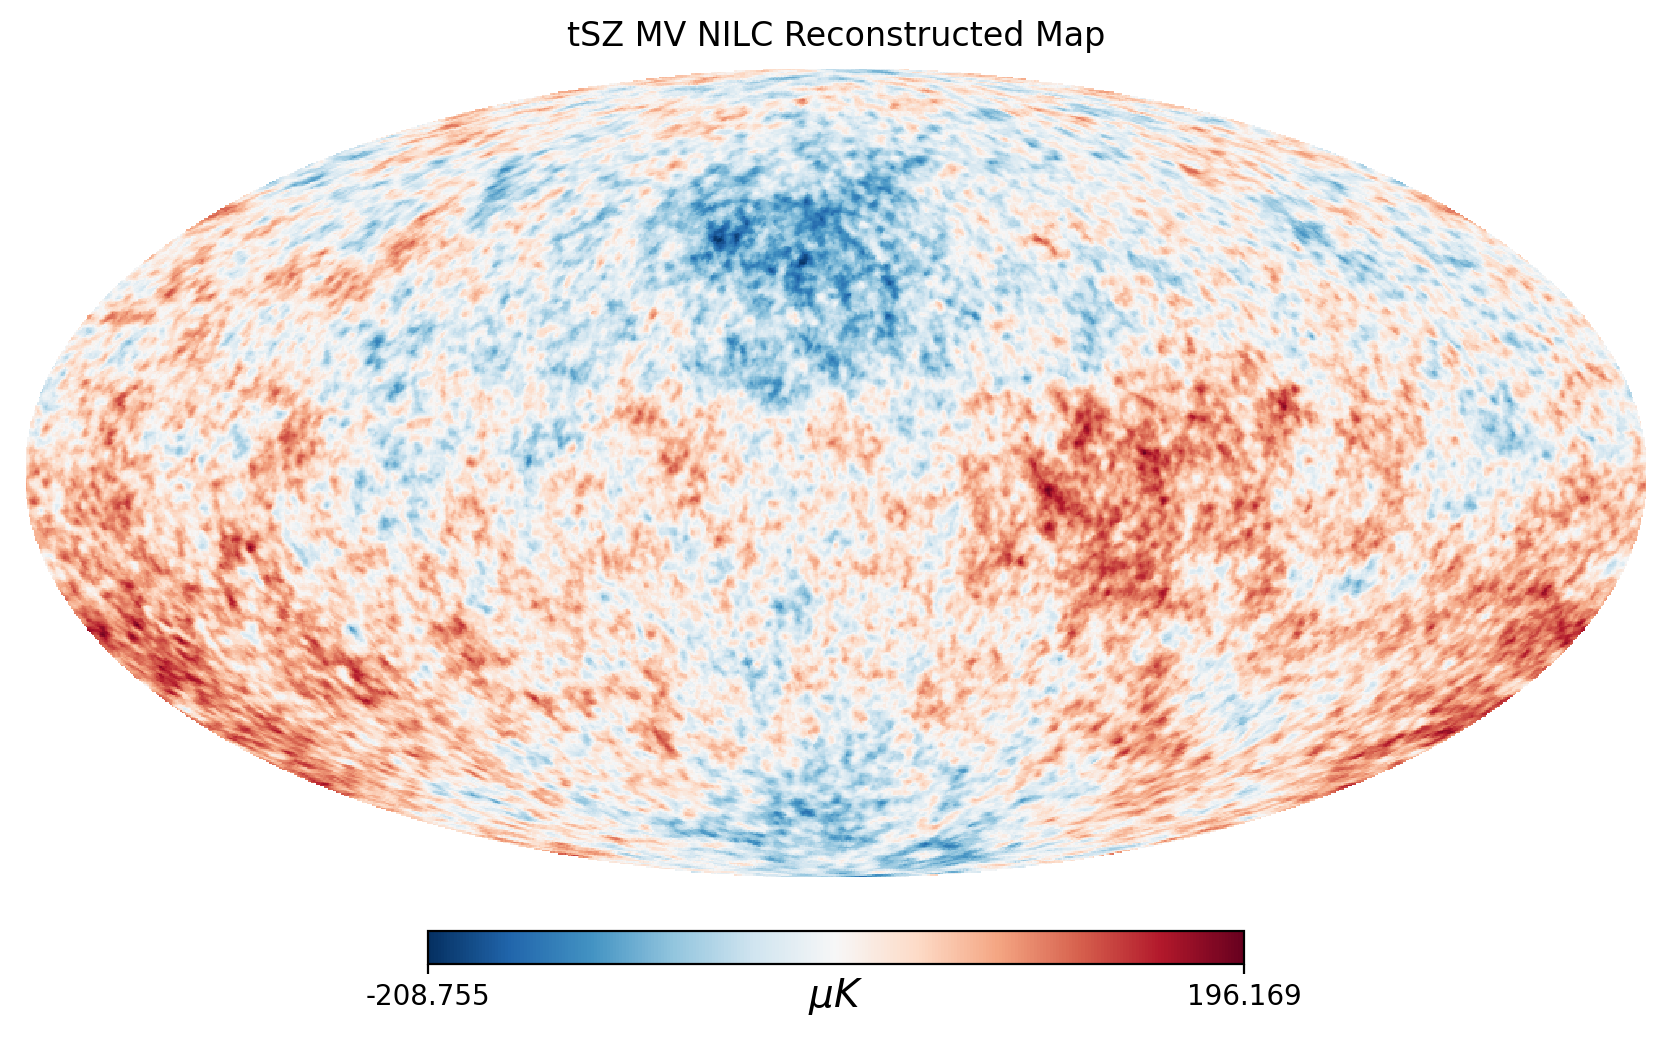

In [ ]:
# tSZ map 
hp.mollview(tsz_map[0], unit=r'$\mu K$', xsize=1000, cmap=cm.RdBu_r, title="tSZ MV NILC Reconstructed Map")

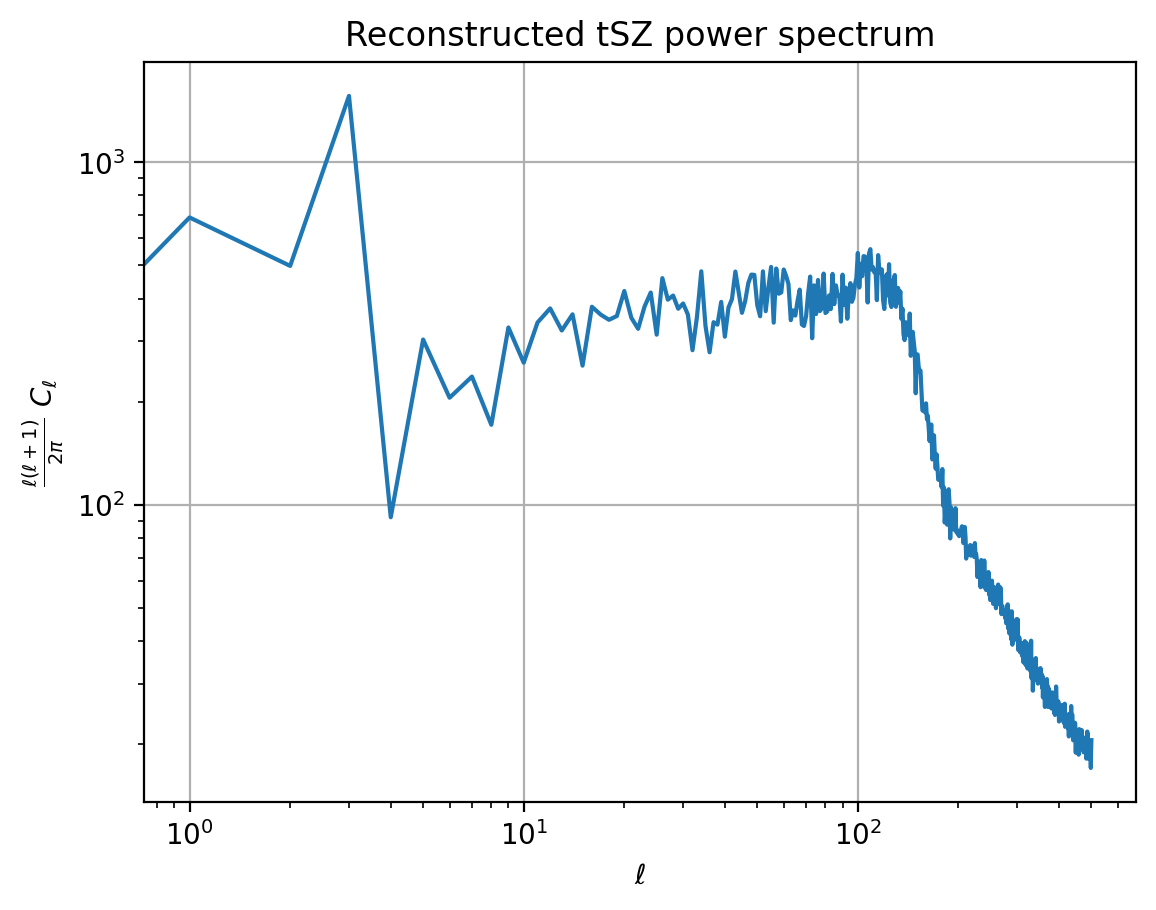

In [ ]:
# checking the power spectrum 
Cl_cmb = hp.anafast(tsz_map[0], lmax=cos.l_max)
ell = np.arange(cos.l_max+1)
Dl_cmb = cl2dl(Cl_cmb, ell)

plt.loglog(ell, Dl_cmb)
plt.grid()
plt.xlabel(r"$\ell$")
plt.ylabel(r'$\frac{\ell(\ell+1)}{2\pi}~C_{\ell}$')
plt.title("Reconstructed tSZ power spectrum")
plt.show()